In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time as time_lib

import numba as nb
from numbalsoda import lsoda_sig, lsoda, dop853
from numba import njit, cfunc

from scripts.dynamics import vecField
from scripts.utils import getCoarse,getNextCoarse

In [4]:
system = "Burger"

n_x = 20
n_t = 3

LB = -1.
UB = 1.

L = 20
weight = np.random.uniform(low=LB,high=UB,size=(L))
bias = np.random.uniform(low=LB,high=UB,size=(L))

vecRef = vecField(system=system)
if system=="Rober":
        k1,k2,k3 = vecRef.k1,vecRef.k2,vecRef.k3
        t_max = 1000.
elif system=="SIR":
        beta,gamma,N = vecRef.beta,vecRef.gamma,vecRef.N
        t_max = 100.
elif system=="Brusselator":
        A,B = vecRef.A,vecRef.B 
        t_max = 12.
elif system=="Arenstorf":
        a,b = vecRef.a,vecRef.b 
        t_max = 17.0652165601579625588917206249 #One period
elif system=="Lorenz":
        sigma,r,b = vecRef.sigma,vecRef.r,vecRef.b
        t_max = 10.
elif system=="Burger":
        nu = vecRef.nu
        dx = vecRef.dx
        t_max = 1.
else:
        print("Dynamics not implemented")
        
time = np.linspace(0,t_max,int(t_max)+1)
dts = np.diff(time)

#### Setting the initial conditions

In [3]:
if system=="Rober":
        y0 = np.array([1.,0.,0])
elif system=="SIR":
        y0 = np.array([0.3,0.5,0.2])
elif system=="Brusselator":
        y0 = np.array([0.,1.])
elif system=="Arenstorf":
        y0 = np.array([0.994,0,0.,-2.00158510637908252240537862224])
elif system=="Lorenz":
        y0 = np.array([20.,5,-5])
elif system=="Burger":
        y0 = np.sin(2*np.pi*vecRef.x)
else:
        print("Dynamics not implemented")

In [4]:
data = {"LB" : LB,
        "UB" : UB,
        "L" : L,
        "y0" : y0,
        "weight" : weight,
        "bias" : bias,
        "n_x" : n_x,
        "n_t" : n_t,
        "system" : system}

In [5]:
from numba import cfunc, types, carray
from numba.types import intc, CPointer, float64

# Define the cfunc signature
c_signature = types.void(types.float64, CPointer(types.float64), CPointer(types.float64), CPointer(types.float64))

In [6]:
@cfunc(lsoda_sig)
def f(t,y,dy,p):
    if system=="Rober":
        dy[0] =  -k1*y[0] + k3 * y[1] * y[2]
        dy[1] = k1*y[0] - k3 * y[1] * y[2] - k2*y[1]**2
        dy[2] = k2*y[1]**2
    elif system=="SIR":
        dy[0] = -beta*y[1]*y[0]/N
        dy[1] = beta*y[0]*y[1]/N - gamma * y[1]
        dy[2]= gamma * y[1]
    elif system=="Brusselator":
        dy[0] = A+y[0]**2*y[1]-(B+1)*y[0]
        dy[1] = B*y[0]-y[0]**2*y[1]
    elif system=="Arenstorf":
        mu = a
        x, y, vx, vy = y[0],y[2],y[1],y[3]
        D1 = ((x + mu)**2 + y**2)**1.5
        D2 = ((x - 1 + mu)**2 + y**2)**1.5
        dy[0] = vx
        dy[1] = x + 2*vy - (1 - mu)*(x + mu)/D1 - mu*(x - 1 + mu)/D2
        dy[2] = vy
        dy[3] = y - 2*vx - (1 - mu)*y/D1 - mu*y/D2
    elif system=="Lorenz":
        dy[0] = -sigma * y[0] + sigma * y[1]
        dy[1] = -y[0]*y[2]+r*y[0]-y[1]
        dy[2] = y[0]*y[1]-b*y[2]
    elif system=="Burger":
        y_array = nb.carray(y, (N,))
        #dy = nb.carray(dy, (50,))

        # We can now use y_array and dy_array as normal Numpy arrays
        # Compute the derivatives, omitting boundaries since they are homogeneous
        for i in range(1, N-1):
            y_x = (y_array[i+1] - y_array[i-1]) / (2 * dx)
            y_xx = (y_array[i+1] - 2 * y_array[i] + y_array[i-1]) / dx**2
            dy[i] = -y_array[i] * y_x + nu * y_xx

        # Boundary conditions
        dy[0] = 0.
        dy[N-1] = 0.0
    else:
        print("Dynamics not implemented")

In [24]:
import numpy as np

N = len(vecRef.x)

y = np.random.randn(N)
y[0] = 0.
y[-1] = 0.
y_x = (np.roll(y, -1) - np.roll(y, 1)) / (2 * dx)
y_x[0] = 0.
y_x[-1] = 0.
vv = np.ones(N-1)
Shift_forward = np.diag(vv,k=1)
Shift_backward = np.diag(vv,k=-1)
Shift_backward[-1]*=0
Shift_forward[0]*=0

#y_x - (Shift_forward @ y - Shift_backward @ y) / (2*dx)
y_xx = (np.roll(y, -1) - 2*y + np.roll(y, 1)) / (dx**2)
y_xx[0] = 0.
y_xx[-1] = 0.

D2 = (Shift_forward + Shift_backward - 2*np.eye(N))/(dx**2)
#D2[0] *= 0.
#D2[-1] *= 0.
y_xx - D2@y


array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.72848411e-12,
        0.00000000e+00,  9.09494702e-13, -1.70530257e-13, -2.27373675e-13,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.81898940e-12, -9.09494702e-13,  0.00000000e+00, -1.70530257e-13,
        9.09494702e-13,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -9.09494702e-13,  4.54747351e-13,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -4.54747351e-13, -4.54747351e-13,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  9.09494702e-13,
        0.00000000e+00, -4.54747351e-13,  2.27373675e-13, -4.54747351e-13,
        0.00000000e+00,  0.00000000e+00,  2.27373675e-13,  0.00000000e+00,
        1.13686838e-13, -4.54747351e-13, -4.54747351e-13,  9.09494702e-13,
        0.00000000e+00,  0.00000000e+00,  2.27373675e-13,  1.81898940e-12,
        1.81898940e-12, -9.09494702e-13,  0.00000000e+00])

In [7]:
funcptr = f.address # address to ODE function

In [8]:
@njit(parallel=True)
def fine_integrator(ics,dts):
    usol = np.zeros_like(ics)
    for i in nb.prange(len(ics)):
        u0 = ics[i]
        uu,_ = dop853(funcptr, u0, t_eval=np.array([0,dts[i]]), rtol = 1e-10, atol = 1e-10)
        usol[i] = uu[-1]
    return usol

In [9]:
from scipy.integrate import solve_ivp

max_it = 30 #maximum number of parareal iterates
tol = 1e-5
computational_times_per_iterate = []
it = 0
is_converged = False

networks = []

while it<max_it and is_converged==False:

    norm_difference = []

    if it==0:
        initial_time = time_lib.time()
        coarse_approx = getCoarse(previous=[],time=time,data=data,networks=networks)
        coarse_values_parareal = coarse_approx.copy()
        computational_times_per_iterate.append(time_lib.time()-initial_time)
            
    else:
        initial_time = time_lib.time()
        coarse_approx = getCoarse(previous=coarse_values_parareal,data=data,time=time,networks=networks)
        
        start_fine = time_lib.time()
        
        fine_int = fine_integrator(coarse_values_parareal,dts)
        print("Time required for the fine solver : ",time_lib.time()-start_fine)
        for i in range(len(time)-1):     
            previous = coarse_values_parareal[i+1].copy()
            coarse_values_parareal[i+1] = fine_int[i] + getNextCoarse(y=coarse_values_parareal[i],i=i,time=time,data=data,networks=networks) - coarse_approx[i+1]
            norm_difference = np.linalg.norm(coarse_values_parareal[i+1]-previous,2)
            
        computational_times_per_iterate.append(time_lib.time()-initial_time)
        print("Maximum norm of difference :",np.round(np.max(norm_difference),10))
        is_converged = np.max(norm_difference)<tol
        
    it+=1
    print(f"Iterate {it} completed")
    print(f"Time for iterate {it} is {computational_times_per_iterate[-1]}")  

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [ ]:
def get_detailed_solution():
    time_plot = np.linspace(0,networks[0].dt,101)
    sol = networks[0].plotOverTimeRange(time_plot)
    total_time = time_plot
    for i in np.arange(1,len(networks)):
        time_plot = np.linspace(0,networks[i].dt,101)[1:]
        sol = np.concatenate((sol,networks[i].plotOverTimeRange(time_plot)),axis=1)
        total_time = np.concatenate((total_time,time_plot+total_time[-1]),axis=0)
    return sol,total_time

In [ ]:
network_sol, time_plot = get_detailed_solution()

In [10]:
initial = time_lib.time()
time_plot = np.linspace(0.,t_max,1000)
output, _ = dop853(funcptr, y0, t_eval=time_plot, rtol=1e-11, atol=1e-10)
final = time_lib.time()
print(f"Computational time : {final-initial}")

Computational time : 0.34906816482543945


In [11]:
if len(y0)==2:
    list_of_labels = [r"$x$",r"$y$"]
elif len(y0)==3:
    list_of_labels = [r"$x$",r"$y$",r"$z$"]
elif len(y0)==4:
    list_of_labels = [r"$x$",r"$\dot{x}$",r"$y$",r"$\dot{y}$"]

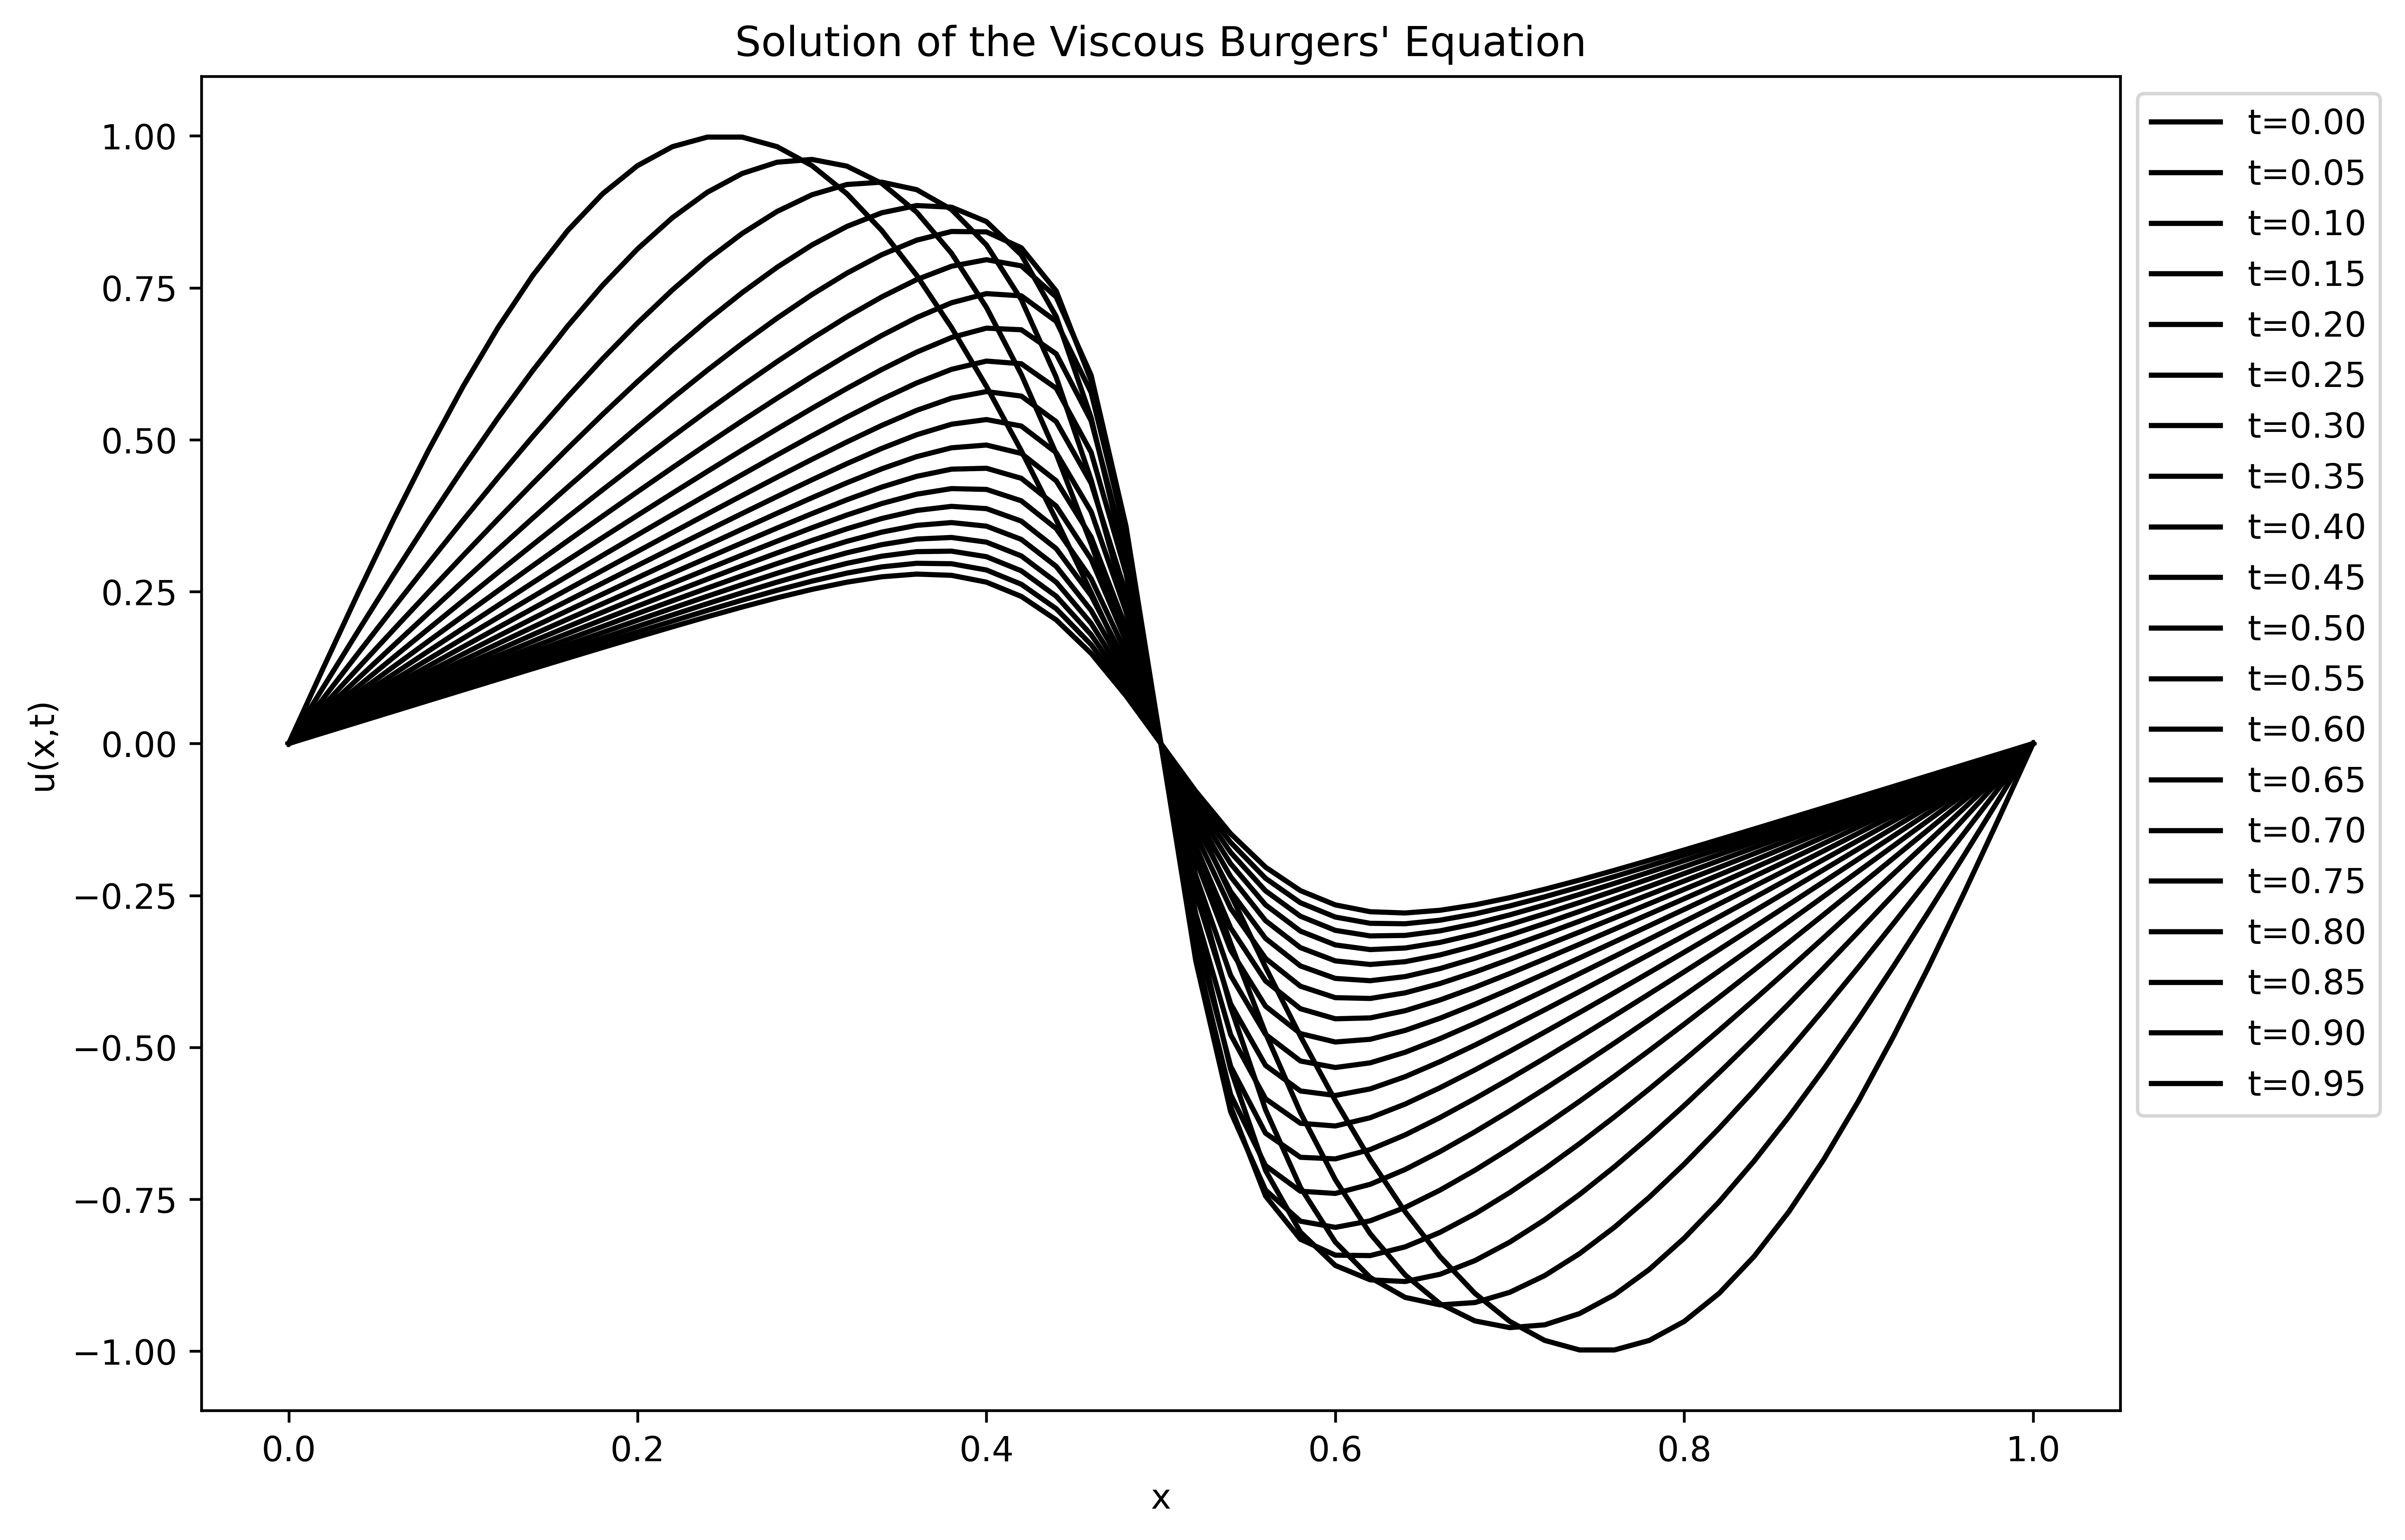

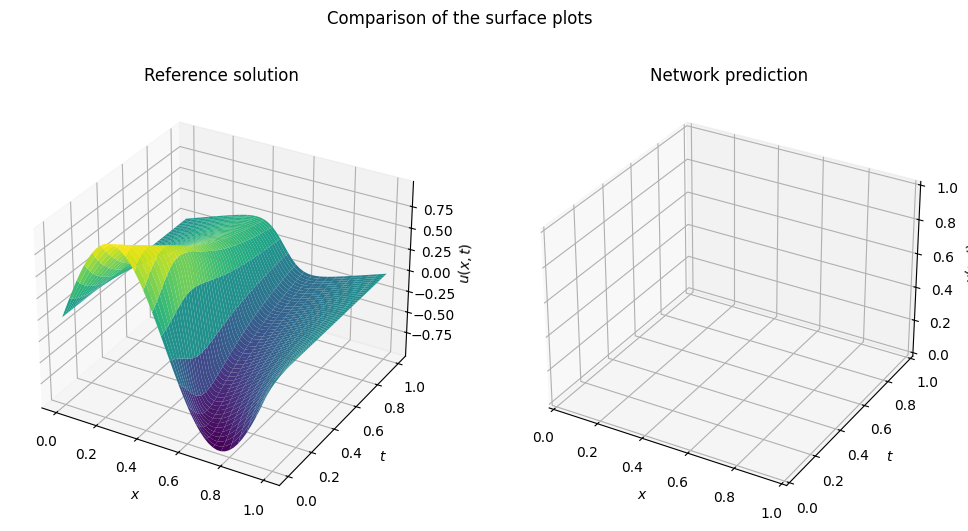

In [21]:

fact = 1e4*(system=="Rober") + 1. * (not system=="Rober")
output, _ = lsoda(funcptr, y0, t_eval=time_plot, rtol=1e-8, atol=1e-8)

if not system=="Burger":
    
    fig = plt.figure(dpi=600)
    
    for i in range(len(y0)):
        if i==1:
            plt.plot(time_plot,output[:,i]*fact,'-',label=f"{list_of_labels[i]} reference")
            plt.plot(time_plot,network_sol[i]*fact,'--',label=f"{list_of_labels[i]} parareal")
        else:
            plt.plot(time_plot,output[:,i],'-',label=f"{list_of_labels[i]} reference")
            plt.plot(time_plot,network_sol[i],'--',label=f"{list_of_labels[i]} parareal")
            
    plt.legend()
    plt.title("Comparison of solutions")
    timestamp = time_lib.strftime("%Y%m%d_%H%M%S")
    plt.savefig(f"savedPlots/pararealPlot_{system}_{timestamp}.pdf")
    plt.show();
    
if system=="Brusselator":
    
    fig = plt.figure(dpi=600)
    
    plt.plot(network_sol[0],network_sol[1],'k-',label="parareal")
    plt.plot(output[:,0],output[:,1],'r--',label="reference")
    
    plt.legend()
    plt.title("Orbits in the phase space")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    timestamp = time_lib.strftime("%Y%m%d_%H%M%S")
    plt.savefig(f"savedPlots/orbits_{system}_{timestamp}.pdf")
    plt.show();
    
if system=="Arenstorf":
    
    fig = plt.figure(dpi=600)
    
    plt.plot(network_sol[0],network_sol[2],'k-',label="parareal")
    plt.plot(output[:,0],output[:,2],'r--',label="reference")
    
    plt.legend()
    plt.title("Orbits in the phase space")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    timestamp = time_lib.strftime("%Y%m%d_%H%M%S")
    plt.savefig(f"savedPlots/orbits_{system}_{timestamp}.pdf")
    plt.show();

if system=="Burger":
    
    fig = plt.figure(dpi=600,figsize=(10,7))
    # Plotting the solution
    for i in range(0, len(time_plot), 50):
        plt.plot(x, output[i],'k-',label=f't={time_plot[i]:.2f}')
        #plt.plot(x, network_sol[:,i],'r--',label=f't={time_plot[i]:.2f}')

    plt.title('Solution of the Viscous Burgers\' Equation')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    timestamp = time_lib.strftime("%Y%m%d_%H%M%S")
    plt.savefig(f"savedPlots/solution_curves_{system}_{timestamp}.pdf")
    
    plt.show()
    
    from mpl_toolkits.mplot3d import Axes3D

    # Creating the meshgrid for x and t
    T, X = np.meshgrid(time_plot, x)

    # Creating the figure

    fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 6))  # 1 row, 2 columns of 3D subplots

    # Plotting the surface
    surf = axs[0].plot_surface(X, T, output.T, cmap='viridis', edgecolor='none')
    #surf = axs[1].plot_surface(X, T, network_sol.T, cmap='viridis', edgecolor='none')

    fig.suptitle('Comparison of the surface plots')

    # Labels and title
    axs[0].set_xlabel(r'$x$')
    axs[0].set_ylabel(r'$t$')
    axs[0].set_zlabel(r'$u(x, t)$')
    axs[0].set_title("Reference solution")
    
    axs[1].set_xlabel(r'$x$')
    axs[1].set_ylabel(r'$t$')
    axs[1].set_zlabel(r'$u(x, t)$')
    axs[1].set_title("Network prediction")

    timestamp = time_lib.strftime("%Y%m%d_%H%M%S")
    plt.savefig(f"savedPlots/solution_surface_{system}_{timestamp}.pdf")
    
    # Show plot
    plt.show()